# Allstate Claims Severity Kaggle Challenge (spring 2018)

### The Problem

Allstate, an US-based insurance company, has for the past couple of years been developing automated
methods of predicting the cost, and hence severity, of claims. In December 2016 it put forward
a recruitment challenge on Kaggle to allow people to show off their creativity and present their
technical skills by creating an algorithm which accurately predicts claims severity. With this the
company hoped to get insight into better ways to predict claims severity and thereby ensure a
more worry-free customer experience. This project takes on the 2016 Allstate challenge and
use the provided datasets on Kaggle. The objective was to compare performance of different machine learning algorithms and methods on the insurance claim dataset from Allstate and to get the best model to predict the accident loss.

### Outline

First the data is observed, transformed and encoded.
Then different prediction methods are used and compared. The methods that are used are 
- Linear Regression
    - Vanilla LR
    - Regularization
        - Ridge
        - Lasso
- Support Vector Machines
- Random Forest
    - Little digression into feature exploration
- Neural Network 


Finally the model that seems to give the best results is trained on the full training set and predictions are made to the submission test provided by Kaggle. 


### Results

The model that had best results was (with no surprise) the neural network. The NN-model really stood out on the leaderboard with around 10% better performance the the second model (RF).

| Model             | training MAE | test MAE |
|-------------------|--------------|----------|
| Linear Regression | 1299.18      | 1312.04  |
| Ridge Regression  | 1286.57      | 1302.32  |
| Lasso Regression  | 1286.35      | 1302.35  |
| SVM               | 1296.36      | 1308.77  |
| Random Forest     | 466.58       | 1251.67  |
| Neural Network    | 1074.78      | 1179.82  |

The submissions were divided into public (multi-submission) and private submission with the prediction MAE being the benchmark. The NN-model ended up scoring a private MAE of 1147.20 and a public MAE of 1138.11. Compared to the leading submission on Kaggle (private MAE of 1109.71), this is an acceptable result.

### Conclusion

What became extremely clear very soon in this project was how much impact the preprocessing of
the data had on the final results for most of the models. It came clear how critical data processing
is in all real life machine learning problems. Future steps would involve transformations and rescaling of the parameters. They worked well as they were but they could probably be massaged to enhance model performance. For the prediction models, the future steps would probably include a bigger process for hyperparameter optimization and a better way for validating (e.g. CV). Regarding the NN model, some methods for reducing the overfitting should definitely be applied (e.g. dropout or some regularization).

## Preprocess

In [1]:
# Libraries ---------------------------------
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import warnings; 
warnings.filterwarnings("ignore") # ignore warnings for the purpose of readability

# Loading and splitting data --------------------------------------
trainData = pd.read_csv("train.csv")
submissionData = pd.read_csv("test.csv")
trainData.drop('cont12',axis=1,inplace=True)
submissionData.drop('cont12',axis=1,inplace=True)

# copy of the data for one hot encoding later on ..
OHE_TrainDataCopy = trainData
OHE_submissionDataCopy = submissionData

# Not interested in the id's (copy kept for submission)
trainData.drop('id',axis=1,inplace=True)
submissionDataIDs = submissionData['id']
submissionData.drop('id',axis=1,inplace=True)

In [2]:
# Categorial encode data both by
#   - Label encoding ([A,B,B,C] -> [1,2,2,3])
#   - One-hot-encoding ([A,B,B,C] -> [A=[1,0,0,0], B=[0,1,1,0], C=[0,0,0,1]])
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)


# If we're not careful, we'll have uneven amounts of catagories in our train and test datasets.
# Handled in 3 steps:

# *1. concat data
Data = pd.concat([trainData, submissionData])

# *2. Categorial encoding
OneHotEncoded_Data = pd.get_dummies(Data)
columns2encode = []
for i in range(116):
    columns2encode.append(list(Data)[i])
Data = MultiColumnLabelEncoder(columns2encode).fit_transform(Data)

# *3. splitting again
#   *3.a one-hot-encoding
OneHotEncoded_trainData = OneHotEncoded_Data[:trainData.shape[0]]
OneHotEncoded_submissionData = OneHotEncoded_Data[trainData.shape[0]:]
OneHotEncoded_submissionData.drop('loss',axis=1,inplace=True)
#    *3.b label encoding ([A,B,B,C] -> [1,2,2,3])
trainData = Data[:trainData.shape[0]]
submissionData = Data[trainData.shape[0]:]
submissionData.drop('loss',axis=1,inplace=True)

# splitting into training, test and validation set 80/20 --------------------------------------
#  *one-hot-encoding
OneHotEncoded_y_trainData = OneHotEncoded_trainData['loss']
OneHotEncoded_X_trainData = OneHotEncoded_trainData[OneHotEncoded_trainData.columns.difference(['loss'])]
OneHotEncoded_X_train, OneHotEncoded_X_test, OneHotEncoded_y_train, OneHotEncoded_y_test = \
train_test_split(OneHotEncoded_X_trainData, OneHotEncoded_y_trainData, test_size=0.2, random_state=20)
#  *label encoding
y_trainData = trainData['loss']
X_trainData = trainData[trainData.columns.difference(['loss'])]
X_train, X_test, y_train, y_test = train_test_split(X_trainData, y_trainData, test_size=0.2, random_state=20)

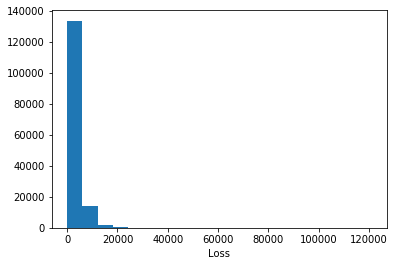

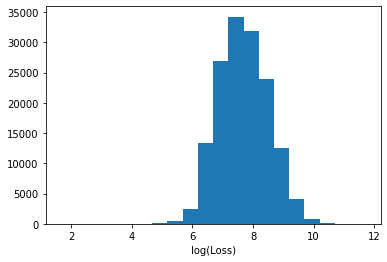

In [3]:
# Log transformation for output variables --------------------------------------

### A quick visualization shows how y values are lognormaly distributed
plt.hist(y_train,20)
plt.xlabel("Loss")
plt.show()

### Log Transformation 
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)
plt.hist(y_train_log,20)
plt.xlabel("log(Loss)")
plt.show()

Reducing dimensions...
Plotting PCA projection...


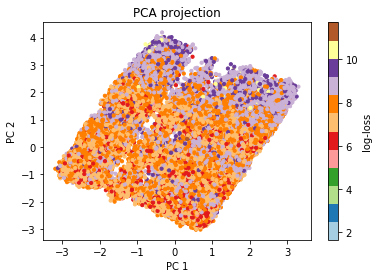

In [4]:
# Dimensionality reduction
from sklearn.decomposition import PCA
import matplotlib.cm as cm

print("Reducing dimensions...")
pca = PCA(n_components=2).fit(OneHotEncoded_X_train)
X2D = pca.transform(OneHotEncoded_X_train)

print("Plotting PCA projection...")
plt.scatter(X2D[:,0],X2D[:,1],cmap=cm.Paired,c = y_train_log,s=10)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA projection')
cbar = plt.colorbar()
cbar.set_label("log-loss")
plt.show()

## Modeling

Few of the models that did best in predicting the output.

In [5]:
# Split our training set further into train and validation
X_train_, X_val_, y_train_log_, y_val_log_ = train_test_split(
    X_train, y_train_log , test_size=0.2, random_state=20)

### Regressions

#### Vanila regression
We'll start of by applying simple linear regression

In [6]:
### Simple Regression ###
from sklearn import linear_model

# Multi-labeled dataset with log(Loss) as an output
reg = linear_model.LinearRegression(fit_intercept=False, normalize=True)
reg.fit(X_train, y_train_log)
y_pred_train_log = reg.predict(X_train)
y_pred_test_log = reg.predict(X_test)
print('--------------------------------------------------------------')
print("Results from simple regression on the multi-labeled dataset:")
print('Training MAE using log transformation:', 
      np.average(abs(np.exp(y_train_log)-np.exp(y_pred_train_log))))
print('Test MAE using log transformation:', 
      np.average(abs(np.exp(y_test_log)-np.exp(y_pred_test_log))))
print('--------------------------------------------------------------')

--------------------------------------------------------------
Results from simple regression on the multi-labeled dataset:
Training MAE using log transformation: 1299.1844015222082
Test MAE using log transformation: 1312.04026607101
--------------------------------------------------------------


#### Shrinkage methods

Regularizations that penalize for bigger number of parameters to avoid overfitting. 
Ridge Rigression and the Lasso.

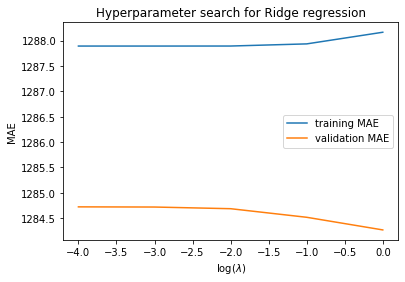

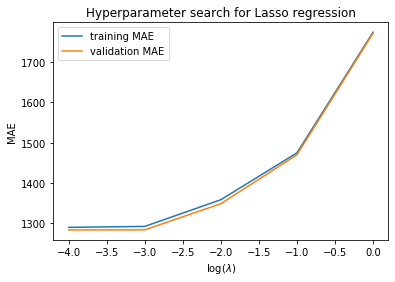

--------------------------------------------------------------------------------------
Results from simple regression on the multi-labeled dataset:
Training MAE using log transformation: 1286.5653087229948
test MAE using log transformation: 1302.3190531806285
--------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------
Results from simple regression on the multi-labeled dataset:
Training MAE using log transformation: 1286.351826057454
test MAE using log transformation: 1302.3492578758494
--------------------------------------------------------------------------------------


In [7]:
def plot_hyp_param_search(alphas, train_MAE, val_MAE, title):
    plt.plot(np.log10(alphas),train_MAE,label='training MAE')
    plt.plot(np.log10(alphas),val_MAE,label='validation MAE')
    plt.xlabel('log($\lambda$)')
    plt.ylabel('MAE')
    plt.title(title)
    plt.legend()
    plt.show()
    
def hyp_param_search(model, alphas, X_train_, y_train_log_, X_val_, y_val_log_, name):
    train_MAE = np.zeros(alphas.shape[0])
    val_MAE = np.zeros(alphas.shape[0])
    for a in range(alphas.shape[0]):
        reg = model(alpha = alphas[a])
        reg.fit(X_train_, y_train_log_)
        y_pred_train_log = reg.predict(X_train_)
        y_pred_val_log = reg.predict(X_val_)
        train_MAE[a] = np.average(abs(np.exp(y_train_log_)-np.exp(y_pred_train_log)))
        val_MAE[a] = np.average(abs(np.exp(y_val_log_)-np.exp(y_pred_val_log)))
    
    plot_hyp_param_search(alphas, train_MAE, val_MAE, 
                      title = "Hyperparameter search for " + name + " regression")
    
    return alphas[np.argmin(val_MAE)]

def eval_perf(reg, X_train, y_train_log, X_test, y_test_log):
    print('--------------------------------------------------------------------------------------')
    reg.fit(X_train, y_train_log)
    y_pred_train_log = reg.predict(X_train)
    y_pred_test_log = reg.predict(X_test)
    print("Results from simple regression on the multi-labeled dataset:")
    print('Training MAE using log transformation:', 
          np.average(abs(np.exp(y_train_log)-np.exp(y_pred_train_log))))
    print('test MAE using log transformation:', 
          np.average(abs(np.exp(y_test_log)-np.exp(y_pred_test_log))))
    print('--------------------------------------------------------------------------------------')

# Hyperparameter search
alphas = 1/np.power(10,np.arange(5))
alpha_Ridge = hyp_param_search(linear_model.Ridge, alphas, X_train_, y_train_log_,
                               X_val_, y_val_log_, name="Ridge")
alpha_Lasso = hyp_param_search(linear_model.Lasso, alphas, X_train_, y_train_log_, 
                               X_val_, y_val_log_, name="Lasso")

# Evaluating the performance of our best hyperparameter on the test set
ridgeReg = linear_model.Ridge(alpha = alpha_Ridge)
eval_perf(ridgeReg, X_train, y_train_log, X_test, y_test_log)
lassoReg = linear_model.Ridge(alpha = alpha_Lasso)
eval_perf(lassoReg, X_train, y_train_log, X_test, y_test_log)

### SVM

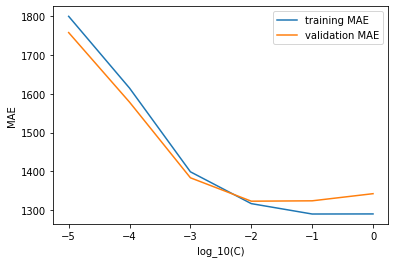

Optimal value of c for validation set: 0.01


In [8]:
from sklearn import svm

# Reduce training set for less computation time
shrinking_factor = 0.01
X_train_small = X_train_[:int(shrinking_factor*X_train_.shape[0])]
y_train_log_small = y_train_log_[:int(shrinking_factor*X_train_.shape[0])]

# Rough search for a good estimate of C on the interval [1,e-6]
C = 1/np.power(10,np.arange(6))
training_MAE = []; test_MAE = []
for c in C:
    SVM = svm.SVR(C=c, kernel='linear', cache_size=1000)
    SVM.fit(X_train_small, y_train_log_small)
    y_train_pred_log = SVM.predict(X_train_small)
    y_val_pred_log = SVM.predict(X_val_)
    training_MAE.append(np.average(abs(np.exp(y_train_log_small) - np.exp(y_train_pred_log))))
    test_MAE.append(np.average(abs(np.exp(y_val_log_) - np.exp(y_val_pred_log))))

plt.plot(np.log10(C), training_MAE,label='training MAE')
plt.plot(np.log10(C), test_MAE,label='validation MAE')
plt.xlabel('log_10(C)')
plt.ylabel('MAE')
plt.legend()
plt.show()

cOpt = C[np.argmin(test_MAE)]
print("Optimal value of c for validation set:", cOpt)

In [9]:
# Evaluate the model on the test set

# Cashed results
MAE_train = 1296.36
MAE_test = 1308.77

modelAll = False # make true if you can wait ~ 30 mins
if modelAll:
    SVM = svm.SVR(C=cOpt, kernel='linear', cache_size=1000)
    SVM.fit(X_train, y_train_log) 
    y_train_pred_log = SVM.predict(X_train)
    y_test_pred_log = SVM.predict(X_test)
    MAE_train = np.average(abs(np.exp(y_train_log) - np.exp(y_train_pred_log)))
    MAE_test = np.average(abs(np.exp(y_test_log) - np.exp(y_test_pred_log)))
    
print("Training MAE using log transformation:", MAE_train)
print("Test MAE using log transformation:", MAE_test)

Training MAE using log transformation: 1296.36
Test MAE using log transformation: 1308.77


### Random Forest

#### Fitting the model

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Gridsearch and model
gridsearch = False
if gridsearch:
    parameters = {
        'max_depth':range(50, 500, 50),
        'max_features':range(10, 20, 2)
    }
    rf = RandomForestRegressor(n_estimators=50, oob_score=False)
    grid = GridSearchCV(rf, parameters)
    grid.fit(X_train, y_train)
    print("Optimal parameters for the grid are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

    # Use our best RF model 
    rf = RandomForestRegressor(
        n_estimators=50,
        max_depth=grid.best_params_['max_depth'],
        max_features=grid.best_params_['max_features'],
        oob_score=False
    )
else:
    # used cashed results from gridsearch
    rf = RandomForestRegressor(n_estimators=50, max_depth=250, max_features=15)

# Fit and test it
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print("Training MAE:",np.average(abs(y_train - y_train_pred)))
print("Test MAE:",np.average(abs(y_test - y_test_pred)))

Training MAE: 466.5807127869157
Test MAE: 1251.667602352379


#### Feature analysis

RF did a good job modelling this problem. Tree methods are very useful for feature exploration so let's have a look. Looking at the top 20 features that best explain the output.

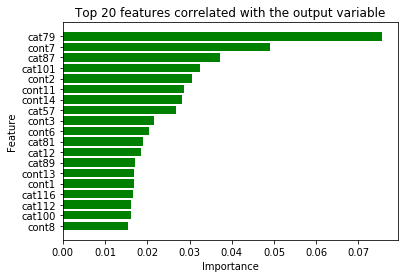

In [11]:
# Explore which features are the most important in RF model
features = list(zip(X_train.columns, rf.feature_importances_))
n = 20
topFeatures = dict(sorted(features, key = lambda x: x[1], reverse=True)[1:n])

fig, ax = plt.subplots()
ax.barh(list(topFeatures.keys()), list(topFeatures.values()), color='green', ecolor='black')
ax.set_yticks(list(topFeatures.keys()))
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title("Top {} features correlated with the output variable".format(n))
plt.show()

### Neural Network

The last model is a simple neural network.

In [54]:
# Re-loading data
trainData = pd.read_csv("train.csv")
submissionData = pd.read_csv("test.csv")

# dropping correlated variables
trainData.drop('cont12',axis=1,inplace=True)
submissionData.drop('cont12',axis=1,inplace=True)

# drop ID but store in submission data
trainData.drop('id',axis=1,inplace=True)
NN_y_train = trainData['loss']
trainData.drop('loss',axis=1,inplace=True)
submissionDataIDs = submissionData['id']
submissionData.drop('id',axis=1,inplace=True)

# one-hot-encoding 
NN_train_Data = pd.get_dummies(trainData)
NN_sub_Data = pd.get_dummies(submissionData)
trainLabels = list(NN_train_Data)
subLabels = list(NN_sub_Data)

for i in range(len(trainLabels)):
    if (not (trainLabels[i] in subLabels)):
        NN_train_Data.drop([trainLabels[i]],axis=1,inplace=True)
        
for i in range(len(subLabels)):
    if (not (subLabels[i] in trainLabels)):
        NN_sub_Data.drop([subLabels[i]],axis=1,inplace=True)

# splitting into training and test set 80/20
OneHotEncoded_X_train, OneHotEncoded_X_test, OneHotEncoded_y_train, OneHotEncoded_y_test = \
train_test_split(NN_train_Data, NN_y_train, test_size=0.2, random_state=20)

# Feed it in as np.arrays
OneHotEncoded_X_train = np.asarray(OneHotEncoded_X_train)
OneHotEncoded_y_train = np.asarray(OneHotEncoded_y_train)
OneHotEncoded_X_test = np.asarray(OneHotEncoded_X_test) 
NN_sub_Data = np.asarray(NN_sub_Data)

Train on 120523 samples, validate on 30131 samples
Epoch 1/100
120523/120523 [==============================] - 7s 55us/sample - loss: 1515.6954 - val_loss: 1283.3407
Epoch 2/100
120523/120523 [==============================] - 6s 50us/sample - loss: 1256.6484 - val_loss: 1221.8640
Epoch 3/100
120523/120523 [==============================] - 6s 50us/sample - loss: 1227.3377 - val_loss: 1213.2148
Epoch 4/100
120523/120523 [==============================] - 6s 49us/sample - loss: 1215.1058 - val_loss: 1204.2415
Epoch 5/100
120523/120523 [==============================] - 6s 49us/sample - loss: 1209.1157 - val_loss: 1191.8160
Epoch 6/100
120523/120523 [==============================] - 6s 51us/sample - loss: 1203.8813 - val_loss: 1188.4940
Epoch 7/100
120523/120523 [==============================] - 6s 52us/sample - loss: 1199.7916 - val_loss: 1198.0066
Epoch 8/100
120523/120523 [==============================] - 7s 56us/sample - loss: 1196.9303 - val_loss: 1243.9541
Epoch 9/100
120523/12

120523/120523 [==============================] - 6s 50us/sample - loss: 1104.8975 - val_loss: 1154.4517
Epoch 71/100
120523/120523 [==============================] - 6s 51us/sample - loss: 1103.8874 - val_loss: 1142.9402
Epoch 72/100
120523/120523 [==============================] - 6s 51us/sample - loss: 1102.9304 - val_loss: 1150.0360
Epoch 73/100
120523/120523 [==============================] - 6s 50us/sample - loss: 1101.8913 - val_loss: 1169.6263
Epoch 74/100
120523/120523 [==============================] - 6s 51us/sample - loss: 1099.5974 - val_loss: 1142.0736
Epoch 75/100
120523/120523 [==============================] - 6s 50us/sample - loss: 1099.0520 - val_loss: 1177.8771
Epoch 76/100
120523/120523 [==============================] - 6s 51us/sample - loss: 1098.4644 - val_loss: 1144.6030
Epoch 77/100
120523/120523 [==============================] - 6s 50us/sample - loss: 1097.0715 - val_loss: 1149.8754
Epoch 78/100
120523/120523 [==============================] - 6s 50us/sample 

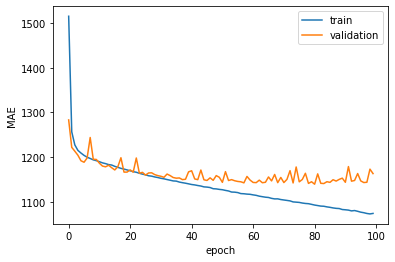

Test MAE: 1179.8226424160018


In [56]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import mean_absolute_error

model = Sequential()
model.add(Dense(500, input_dim=OneHotEncoded_X_train.shape[1]))
model.add(Activation('relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='sgd')

history = model.fit(OneHotEncoded_X_train, OneHotEncoded_y_train,
                    epochs=100, batch_size=128, validation_split=0.2, shuffle=True,verbose=1)

# Visualizing the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

y_pred = model.predict(OneHotEncoded_X_test)
test_error = mean_absolute_error(OneHotEncoded_y_test, y_pred)
print("Test MAE:", test_error)

In [57]:
# Model the submission set (final test) with NN model (Best performance)
y_pred_submission = model.predict(NN_sub_Data)
with open("testSubmissionFile.csv", "w") as subfile:
    subfile.write("id,loss\n")
    for i, prediction in enumerate(list(y_pred_submission)):
        subfile.write("%s,%s\n"%(submissionDataIDs[i],prediction[0]))